# 5. Analyze & Share phase
## 5.1 Feature Selection

I'll use some of the methods to select the features that would provide the best patterns or insights. These would be:

1. Correlation
2. Extra Trees Regressor
3. RFECV
4. Linear Regression
5. Lasso (L1 reg)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

import matplotlib.pyplot as plt
import seaborn as sns

import os
import time 
import re

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data/news_share_data_selected.csv')
print(df.shape)
df.head()

(1000, 32)


,cleaned_title,cleaned_text,weekday,is_weekend,month,month number,weekday number,title_tokens,text_tokens,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
0,time youtube competitor,reported last week yahoo getting online video ...,Monday,0,March,1,1,7,195,Business,0,0,0,0,0,0.640816,5,3,1,4.579592,5,1459.500,4817.692,3370.415,1833.333,0.403762,0.038762,0.036735,0.024490,0.25,0.25,1600
1,ultimate roundup 2014s biggest april fools day...,april fools marks day pranking goes corporate ...,Tuesday,0,April,0,5,12,108,Tech,0,0,0,0,1,0.549618,4,1,0,4.636704,7,0.000,3581.094,2556.367,8500.000,0.410707,0.180934,0.044944,0.003745,0.00,0.00,1500
2,selfie one garish jacket red sox white house,2013 world series champion boston red sox visi...,Tuesday,0,April,0,5,15,517,Tech,0,0,0,0,1,0.577236,8,1,0,4.627451,7,2270.889,3852.800,3018.167,2076.333,0.397545,0.044864,0.035294,0.019608,0.00,0.00,1400
3,african telecom proposes diverse emoticons,less week apple pledged make emoticons raciall...,Tuesday,0,April,0,5,6,283,Tech,0,0,0,0,1,0.525896,4,1,0,5.083665,9,0.000,3581.094,1871.403,2200.000,0.491578,0.157620,0.047809,0.011952,0.00,0.00,1300
4,google launch improved android camera app repo...,android users may soon see series new features...,Tuesday,0,April,0,5,10,282,Others,0,0,1,0,0,0.588889,6,9,0,4.336022,7,3581.094,8453.451,5155.323,805.000,0.628535,0.078497,0.053763,0.034946,0.00,0.00,3000


### 5.1.2 Extra Trees Regressor (feature_importance_)

**workin with all the numerical values**

In [5]:
df.columns

Index(['cleaned_title', 'cleaned_text', 'weekday', 'is_weekend', 'month',
       'month number', 'weekday number', 'title_tokens', 'text_tokens',
       'cleaned_data_channel', 'Channel_Entertainment', 'Channel_Lifestyle',
       'Channel_Others', 'Channel_Social Media', 'Channel_Tech',
       'unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares'],
      dtype='object')

In [16]:
num_df = df.drop(columns = ['cleaned_title', 'cleaned_text','cleaned_data_channel','weekday','month'])
num_df.head(1)

,is_weekend,month number,weekday number,title_tokens,text_tokens,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
0,0,1,1,7,195,0,0,0,0,0,0.640816,5,3,1,4.579592,5,1459.5,4817.692,3370.415,1833.333,0.403762,0.038762,0.036735,0.02449,0.25,0.25,1600


In [17]:
x= num_df.drop(columns ='shares') #features
y= num_df['shares'] #label

In [18]:
#fitting the train data
from sklearn.ensemble import ExtraTreesRegressor
choose = ExtraTreesRegressor()
choose.fit(x,y)

ExtraTreesRegressor()

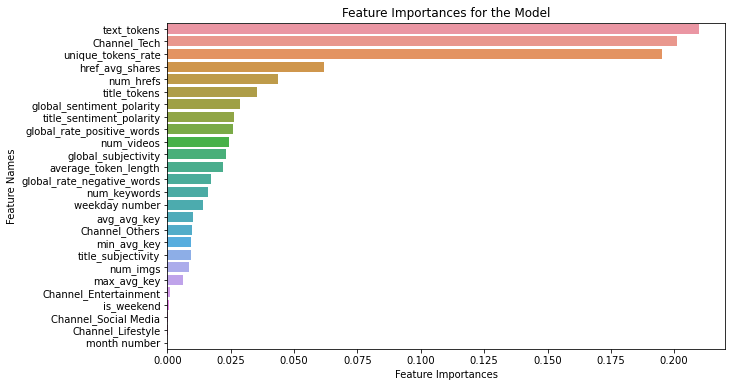

In [19]:
#showing in graph which are the important features we got..
feature_importances = choose.feature_importances_
feature_names = x.columns

# Create a DataFrame with feature importances and their corresponding names
sorted_feature_importances = pd.DataFrame({'Feature Importance': feature_importances, 'Feature Names': feature_names})

# Sort the DataFrame based on feature importances in descending order
sorted_feature_importances = sorted_feature_importances.sort_values(by='Feature Importance', ascending=False)

# Plot the sorted feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature Importance', y='Feature Names', data=sorted_feature_importances)
plt.xlabel('Feature Importances')
plt.ylabel('Feature Names')
plt.title('Feature Importances for the Model')
plt.savefig('fig-4.png')
plt.show()

### 5.1.3 RFECV


In [20]:
#separating train and test(library/API)
from sklearn.model_selection import train_test_split
#ensembling all by means of rf regressor since its a regresion problem
from sklearn.ensemble import RandomForestRegressor
#We will create a way by an algorithm that eliminates useless features after every iteration and obviously after an ensemble technique
from sklearn.feature_selection import RFECV
#finding the desired score
from sklearn.metrics import mean_squared_error

In [21]:
#Creation phase..
X_train, X_test, y_train, y_test = train_test_split(num_df,y, test_size = 0.25)

# Create the RandomForestRegressor model
rfr = RandomForestRegressor()

# Create the RFECV model with the RandomForestRegressor
#The negative sign is used because RFECV always maximizes the scoring metric, but we typically want to minimize the MSE.
rfecv = RFECV(estimator = rfr, cv =5, scoring ='neg_mean_squared_error')

In [22]:
#Fitting phase
rfecv.fit(X_train, y_train)
#getting the selected features by rfecv support into X_train
selected_features = X_train.columns[rfecv.support_]

## 5.2 Ensembling(Random Forest Regressor)


In [23]:
#ensembling phase
# Train the RandomForestRegressor on the selected features
rfr.fit(X_train[selected_features], y_train)
#finally predict on test data
y_pred = rfr.predict(X_test[selected_features])

In [24]:
from sklearn.metrics import r2_score
#scoring 
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')

R2 score: 0.9702017487510084


Here, the training score is too high which means **Overfitting**, so we will go with Linear and lasso

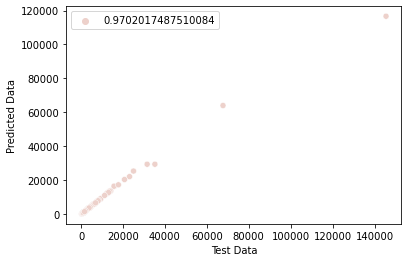

In [26]:
sns.scatterplot(x=y_test, y=y_pred, hue=r2,alpha=1)
plt.xlabel("Test Data")
plt.ylabel("Predicted Data")

plt.show()

## 4. Linear Regression

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = num_df.drop(columns=['shares'])  # Features (excluding 'shares')
y = num_df['shares']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

# Coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Mean Squared Error: 60766321.23235924
Root Mean Squared Error: 7795.275571290552
R-squared: -2.097895312837349
Coefficients: [-8.31232048e+02  5.05410694e+03 -2.87867399e+00  3.36078732e+02
  1.00242367e+01  1.36903702e+03 -3.12754903e+03  5.22394990e+02
  1.32372834e+03  5.20095000e+03 -2.37840186e+04  1.22403061e+02
 -2.13093700e+02 -1.52783839e+02  1.45403613e+03  1.58390963e+02
 -1.09704896e+00 -3.41122086e-01  2.15781714e+00  4.53363648e-04
  1.34366654e+04 -3.80939192e+03 -9.42358310e+04  6.69783448e+03
  2.82265949e+00  4.11713311e+03]
Intercept: -6826.950563976306


Again, the r-score is bad and wil be underfitting

## 5. Lasso Regression 

In [33]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso_model = Lasso(alpha=1.0)  

lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)




Mean Squared Error: 60128572.669605605
Root Mean Squared Error: 7754.261581195569
R-squared: -2.0653825945543285


## hyperparameter tuning

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import numpy as np
from scipy.stats import randint

#assigning the ensemble learning model
rf_classifier = RandomForestClassifier()

#generating the parameter distributions
# Define hyperparameter space for RandomizedSearchCV

param_dist = {
    'n_estimators': np.linspace(10, 100, num=10, dtype='int'),
    'max_depth': randint(1, 10),
    'max_features': ['auto', 'sqrt'],  # Added a comma here cz of dictionary
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False]
}

# Create RandomizedSearchCV object

rf_comb = RandomizedSearchCV(
    estimator=rf_classifier, 
    param_distributions=param_dist, 
    scoring='neg_mean_squared_error', 
    verbose=2, 
    cv=5, 
    random_state=42,
    n_iter = 7
)
# Fit the RandomizedSearchCV object to the data
rf_comb.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=40; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=40; total time=   0.0s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=7,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EE43612DF0>,
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EE1DB1B760>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EE4363E520>,
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [35]:
#printing our best parameter
print(f'Best HyperParameters are: {rf_comb.best_params_}\n')
print("Best Score:", rf_comb.best_score_)

Best HyperParameters are: {'bootstrap': False, 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 70}

Best Score: -644539270.33875


In [36]:
#predicting and using it for later purposes
rsc_pred = rf_comb.predict(X_test)

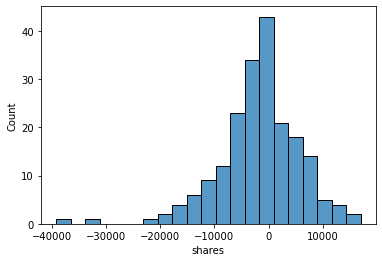

In [37]:
sns.histplot(y_test-y_pred)
plt.show()

In [40]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, rsc_pred))
print('R2:', metrics.r2_score(y_test, rsc_pred))
print('MSE:', metrics.mean_squared_error(y_test, rsc_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rsc_pred)))

MAE: 2123.82
R2: -0.15324601462000742
MSE: 22621331.81
RMSE: 4756.188790407715
